In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import copy
import pandas as pd
from torchensemble import BaggingClassifier, utils, BaggingClassifier
from torchensemble.utils import operator as op
from torchensemble.utils import io
import warnings
from torchsummary import summary
import cooler
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import optim
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import patches
from tqdm import tqdm
from torchvision.transforms import GaussianBlur

In [2]:
local_path = 'D:/Study/HICT/HICT_Patterns/'
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class DetectModelSmall(nn.Module):
    def __init__(self, in_channels=3, image_size=40, num_classes=2):
            super(DetectModelSmall, self).__init__()
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, 8,  kernel_size = 3, padding=1),
                #image_size x image_size x 8
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(kernel_size=2, stride=2),
                #image_size/2 x image_size/2 x 8
                nn.Conv2d(8, 32,  kernel_size = 3, padding=1),
                #image_size/2 x image_size/2 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                #image_size/4 x image_size/4 x 32
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                #image_size/4 x image_size/4 x 64
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                #image_size/8 x image_size/8 x 64
                nn.Flatten(),
                nn.Linear(image_size//8*image_size//8*64, 512),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )

    def forward(self, x):
        x = self.layers(x)
        return x

In [4]:
def calculate_diag_means(matrix: np.ndarray, res = 'exp/obs') -> np.ndarray:
        result = np.zeros_like(matrix, dtype='float64')
        expected = np.zeros_like(matrix, dtype='float64')
        assert (
            matrix.shape[0] == matrix.shape[1]
        ), "Matrix must be square"
        if True:
            n = matrix.shape[0]
            expected = sum(
                (
                    np.diag(
                        [np.nanmean(matrix.diagonal(offset=i))] * (n-abs(i)), k=i
                    ) for i in range(1-n, n)
                )
            )
        else:
            expected = np.ones_like(matrix) * np.nanmean(matrix)

        if res == 'exp/obs':
            return expected/matrix

        if res == 'exp':
            return expected

        if res == 'exp-obs':
            return expected - matrix

        if res == 'obs-exp':
            return matrix - expected

        if res == 'obs/exp':
            return matrix/expected

        return result

## Define train dataset

In [23]:
class TrainDatasetPatches(Dataset):
    def __init__(self, cooler_path_list, trans_csv_path_list, resolution, image_size, clean_cooler,detection=True):
        sv_count = 0
        self.label_to_index = {'copy_loss':torch.tensor([0.0, 0.0, 1.0]),
                               'inversion':torch.tensor([0.0, 1.0, 0.0]),
                               'negative':torch.tensor([1.0, 0.0, 0.0])}
        self.resolution = resolution
        self.image_size = image_size
        self.detection = detection
        self.blur = GaussianBlur(kernel_size=3, sigma=1)
        self.clean_cooler = cooler.Cooler(f'{clean_cooler}::/resolutions/{resolution}')
        indexes = {'file_index':[], 'in_index':[], 'is_sv':[]}
        self.coolers_list = []
        self.sv_files_list = []
        for trans_csv_path, cooler_path, index in zip(trans_csv_path_list, cooler_path_list, range(len(trans_csv_path_list))):
            sv_file = pd.read_csv(trans_csv_path)
            
            sv_count+=sv_file.shape[0]
            c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
            self.coolers_list.append(c)
            neg_sv = {'chr':[], 'label':[], 'start':[], 'end':[]}
            for i, sv in sv_file.iterrows():
                indexes['file_index'].append(index)
                indexes['in_index'].append(i)
                indexes['is_sv'].append(True)
                
                chr_size = np.sum(self.clean_cooler.chromsizes.values)
                x = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                y = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                neg_sv['chr'].append(sv.chr)
                neg_sv['label'].append('negative')
                neg_sv['start'].append(x)
                neg_sv['end'].append(y)

                indexes['file_index'].append(index)
                indexes['in_index'].append(sv_file.shape[0]+i)
                indexes['is_sv'].append(False)
            sv_file = pd.concat([sv_file, pd.DataFrame(neg_sv)])
            self.sv_files_list.append(sv_file)
        if detection:
            self.num_classes = 2
        else:     
            self.num_classes = len(self.sv_files_list[0].label.unique()) + 1
        self.indexes = pd.DataFrame(indexes)

    def __len__(self):
        return self.indexes.shape[0]

    def __getitem__(self, idx):
        row = self.indexes.iloc[[idx]]
        if row.is_sv.iloc[0]:
            c = self.coolers_list[row.file_index.iloc[0]]
        else:
            c = self.clean_cooler
        sv_info = self.sv_files_list[row.file_index.iloc[0]]
        try:
            sv_info = sv_info.iloc[[row.in_index.iloc[0]]]
        except IndexError:
            print(row.in_index.iloc[0])
            print(sv_info)
            k = 1 /0
        chr_margin = 0
        if row.is_sv.iloc[0]:
            for t_chr in c.chromnames:
                if t_chr!=sv_info.chr.iloc[0]:
                    chr_margin+=c.chromsizes[t_chr]//self.resolution
                else:
                    break
        x = chr_margin+sv_info.start.iloc[0]//self.resolution
        y = chr_margin+sv_info.end.iloc[0]//self.resolution
        pad = self.image_size//2
        #if row.is_sv.iloc[0]:
        #    x += random.randint(-pad//2, pad//2)
        #    y += random.randint(-pad//2, pad//2)
        if x-pad < 0 or y - pad < 0:
            mv = max(-(x-pad), -(y-pad))
            x+=mv
            y+=mv
        mat = c.matrix(balance=False)[x-pad:x+pad, y-pad:y+pad]
        mat = np.log10(mat)
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        #mat = calculate_diag_means(mat, 'obs/exp')
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)
        if self.detection:
            return tens, 1 if row.is_sv.iloc[0] else 0
        else:
            return tens, self.label_to_index[sv_info.label.iloc[0]]

In [22]:
class TrainDatasetDiagonal(Dataset):
    def __init__(self, cooler_path_list, trans_csv_path_list, resolution, image_size, clean_cooler,detection=True):
        sv_count = 0
        self.resolution = resolution
        self.image_size = image_size
        self.detection = detection
        self.blur = GaussianBlur(kernel_size=3, sigma=1)
        self.clean_cooler = cooler.Cooler(f'{clean_cooler}::/resolutions/{resolution}')
        indexes = {'file_index':[], 'in_index':[], 'is_sv':[]}
        self.coolers_list = []
        self.sv_files_list = []
        for trans_csv_path, cooler_path, index in zip(trans_csv_path_list, cooler_path_list, range(len(trans_csv_path_list))):
            sv_file = pd.read_csv(trans_csv_path)
            
            sv_count+=sv_file.shape[0]
            c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
            self.coolers_list.append(c)
            neg_sv = {'chr':[], 'label':[], 'start':[], 'end':[]}
            for i, sv in sv_file.iterrows():
                indexes['file_index'].append(index)
                indexes['in_index'].append(i)
                indexes['is_sv'].append(True)
                
                chr_size = np.sum(self.clean_cooler.chromsizes.values)
                neg_sv['chr'].append(sv.chr)
                neg_sv['label'].append('0')
                x = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                y = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                neg_sv['start'].append(x)
                neg_sv['end'].append(y)

                indexes['file_index'].append(index)
                indexes['in_index'].append(sv_file.shape[0]+i)
                indexes['is_sv'].append(False)
            sv_file = pd.concat([sv_file, pd.DataFrame(neg_sv)])
            self.sv_files_list.append(sv_file)
        if detection:
            self.num_classes = 2
        else:     
            self.num_classes = len(self.sv_files_list[0].label.unique()) + 1
        self.indexes = pd.DataFrame(indexes)

    def __len__(self):
        return self.indexes.shape[0]*2

    def __getitem__(self, idx_double):
        idx = idx_double//2
        row = self.indexes.iloc[[idx]]
        if row.is_sv.iloc[0]:
            c = self.coolers_list[row.file_index.iloc[0]]
        else:
            c = self.clean_cooler
        sv_info = self.sv_files_list[row.file_index.iloc[0]]
        try:
            sv_info = sv_info.iloc[[row.in_index.iloc[0]]]
        except IndexError:
            print(row.in_index.iloc[0])
            print(sv_info)
            k = 1 /0
        chr_margin = 0
        if row.is_sv.iloc[0]:
            for t_chr in c.chromnames:
                if t_chr!=sv_info.chr.iloc[0]:
                    chr_margin+=c.chromsizes[t_chr]//self.resolution
                else:
                    break
        if idx_double % 2 == 0:
            x = chr_margin+sv_info.start.iloc[0]//self.resolution
            y = chr_margin+sv_info.start.iloc[0]//self.resolution
        else:
            x = chr_margin+sv_info.end.iloc[0]//self.resolution
            y = chr_margin+sv_info.end.iloc[0]//self.resolution
        pad = self.image_size//2
        if row.is_sv.iloc[0]:
            mv_r = random.randint(-pad//4, pad//4)
            x += mv_r
            y += mv_r
        if x-pad < 0 or y - pad < 0:
            mv = max(-(x-pad), -(y-pad))
            x+=mv
            y+=mv
        mat = c.matrix(balance=False)[x-pad:x+pad, y-pad:y+pad]
        mat = np.log10(mat)
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)
        if self.detection:
            return tens,  float(1) if row.is_sv.iloc[0] else float(0)
        else:
            return tens, sv_info.label.iloc[0]



## Create datasets

In [75]:
train_coolers = []
train_csvs = []
test_coolers = []
test_csvs = []
for prefix_cool, prefix_csv in zip(
            ('_long_', '2_long_', '_short_2_' ),
            ('_long','_long', '_short_2')):
    train_coolers.append(f'{local_path}data/ZANU/ZANU{prefix_cool}4DN.mcool')
    train_csvs.append(f'{local_path}data/ZANU/transitions{prefix_csv}.csv',)
for prefix_cool, prefix_csv in zip(
            ('_short_', '2_short_', '2_short_2_' ),
            ('_short', '_short', '_short_2')):
    test_coolers.append(f'{local_path}data/ZANU/ZANU{prefix_cool}4DN.mcool')
    test_csvs.append(f'{local_path}data/ZANU/transitions{prefix_csv}.csv',)
train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=5000,
    image_size=24,
    detection=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TrainDatasetPatches(
    cooler_path_list=test_coolers,
    trans_csv_path_list=test_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=5000,
    image_size=24,
    detection=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

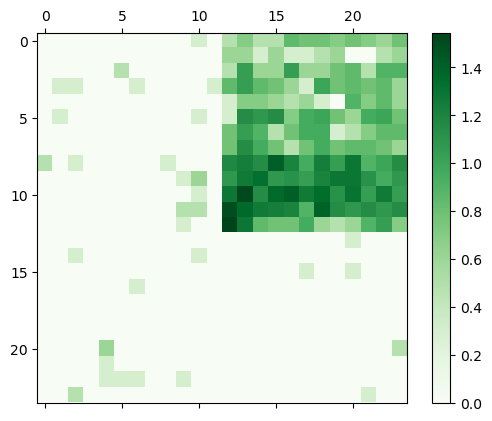

In [76]:
for batch in train_dataloader:
    for data, label in zip(batch[0], batch[1]):
        if label == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            im = ax.matshow(data.cpu().numpy().reshape((24, 24)), cmap='Greens')
            fig.colorbar(im)
            break
    break

In [8]:
def _parallel_fit_per_epoch(
    train_loader,
    estimator,
    cur_lr,
    optimizer,
    criterion,
    idx,
    epoch,
    log_interval,
    device,
    is_classification,
):
    """
    Private function used to fit base estimators in parallel.

    WARNING: Parallelization when fitting large base estimators may cause
    out-of-memory error.
    """
    if cur_lr:
        # Parallelization corrupts the binding between optimizer and scheduler
        utils.set_module.update_lr(optimizer, cur_lr)

    for batch_idx, elem in enumerate(train_loader):

        data, target = io.split_data_target(elem, device)
        batch_size = data[0].size(0)

        optimizer.zero_grad()
        output = estimator(*data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Print training status
        if batch_idx % log_interval == 0:
            # Classification
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == target).sum().item()

            msg = (
                "Estimator: {:03d} | Epoch: {:03d} | Batch: {:03d}"
                " | Loss: {:.5f} | Correct: {:d}/{:d}"
            )
            print(
                msg.format(
                    idx, epoch, batch_idx, loss, correct, batch_size
                )
            )

    return estimator, optimizer

class EnsembleModel(BaggingClassifier):

    def asemble(self, num_classes):
        self.n_outputs = num_classes

        # Instantiate a pool of base estimators, optimizers, and schedulers.
        self.estimators = []
        for _ in range(self.n_estimators):
            self.estimators.append(self._make_estimator())

        self.optimizers = []
        for i in range(self.n_estimators):
            self.optimizers.append(
                utils.set_module.set_optimizer(
                    self.estimators[i], self.optimizer_name, **self.optimizer_args
                )
            )
        if self.use_scheduler_:
            self.scheduler_ = utils.set_module.set_scheduler(
                self.optimizers[0], self.scheduler_name, **self.scheduler_args
            )

        # Check the training criterion
        if not hasattr(self, "_criterion"):
            self._criterion = nn.CrossEntropyLoss()
        
        self.estimators_ = nn.ModuleList()
        self.estimators_.extend(self.estimators)
    

    def fit(self, train_loader, epochs=100, log_interval=100, test_loader=None, save_model=True, save_dir=None):

        self._validate_parameters(epochs, log_interval)
        self.n_outputs = self._decide_n_outputs(train_loader)

        # Instantiate a pool of base estimators, optimizers, and schedulers.
        estimators = self.estimators

        optimizers = self.optimizers

        if self.use_scheduler_:
            scheduler_ = self.scheduler_

        # Utils
        best_acc = 0.0

        # Internal helper function on pesudo forward
        def _forward(estimators, *x):
            outputs = [
                F.softmax(estimator(*x), dim=1) for estimator in estimators
            ]
            proba = op.average(outputs)

            return proba

        # Maintain a pool of workers
        with Parallel(n_jobs=self.n_jobs) as parallel:

            # Training loop
            for epoch in range(epochs):
                self.train()

                if self.use_scheduler_:
                    cur_lr = scheduler_.get_last_lr()[0]
                else:
                    cur_lr = None

                if self.n_jobs and self.n_jobs > 1:
                    msg = "Parallelization on the training epoch: {:03d}"
                    self.logger.info(msg.format(epoch))

                rets = parallel(
                    delayed(_parallel_fit_per_epoch)(
                        train_loader,
                        estimator,
                        cur_lr,
                        optimizer,
                        self._criterion,
                        idx,
                        epoch,
                        log_interval,
                        self.device,
                        True,
                    )
                    for idx, (estimator, optimizer) in enumerate(
                        zip(estimators, optimizers)
                    )
                )

                estimators, optimizers = [], []
                for estimator, optimizer in rets:
                    estimators.append(estimator)
                    optimizers.append(optimizer)

                # Validation
                if test_loader:
                    self.eval()
                    with torch.no_grad():
                        correct = 0
                        total = 0
                        for _, elem in enumerate(test_loader):
                            data, target = io.split_data_target(
                                elem, self.device
                            )
                            output = _forward(estimators, *data)
                            _, predicted = torch.max(output.data, 1)
                            correct += (predicted == target).sum().item()
                            total += target.size(0)
                        acc = 100 * correct / total

                        if acc > best_acc:
                            best_acc = acc
                            self.estimators_ = nn.ModuleList()
                            self.estimators_.extend(estimators)
                            if save_model:
                                io.save(self, save_dir, self.logger)

                        msg = (
                            "Epoch: {:03d} | Validation Acc: {:.3f}"
                            " % | Historical Best: {:.3f} %"
                        )
                        print(msg.format(epoch, acc, best_acc))
                        if self.tb_logger:
                            self.tb_logger.add_scalar(
                                "voting/Validation_Acc", acc, epoch
                            )

                # Update the scheduler
                with warnings.catch_warnings():

                    # UserWarning raised by PyTorch is ignored because
                    # scheduler does not have a real effect on the optimizer.
                    warnings.simplefilter("ignore", UserWarning)

                    if self.use_scheduler_:
                        scheduler_.step()

        self.estimators_ = nn.ModuleList()
        self.estimators_.extend(estimators)
        if save_model and not test_loader:
            io.save(self, save_dir, self.logger)
    

In [18]:
from collections import OrderedDict

class DetectBlock(nn.Module):
    def __init__(self, in_channels):
            super(DetectBlock, self).__init__()
            layers = nn.Sequential(
                #image_size x image_size x 1
                nn.Conv2d(in_channels, 3,  kernel_size = 3, padding=1),
                #image_size x image_size x 3
                nn.BatchNorm2d(3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(3, 8,  kernel_size = 3, padding=1),
                #image_size/2-1 x image_size/2 x 8
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=True),
                nn.Conv2d(8, 32,  kernel_size = 3, padding=1),
                #image_size/2-1 x image_size/2 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                #(image_size/2-1)/2-1 x image_size/4 x 32
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                #(image_size/2-1)/2-1 x image_size/4 x 64
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                #((image_size/2-1)/2-1)/2 x image_size/8 x 64
            )
            self.add_module('seq_layer', layers)

    def forward(self, x):
        output = self.seq_layer(x)
        return output

class DetectAssembleBlock(nn.ModuleDict):
    def __init__(self, in_channels, num_models):
        super(DetectAssembleBlock, self).__init__()
        for i in range(num_models):
            block = DetectBlock(in_channels)
            self.add_module('mini_block%d' % (i + 1), block)

    def forward(self, x):
        features = []
        for name, layer in self.items():
            output = layer(x)
            features.append(output)
        return torch.cat(features, 1)

class DetectModel(nn.Module):
    def __init__(self, in_channels=1, image_size=40, num_models=10):
        super(DetectModel, self).__init__()
        
        self.features = nn.Sequential(OrderedDict([]))
        self.features.add_module('super_block', DetectAssembleBlock(in_channels, num_models))

        num_features = ((image_size//8)**2) * 64 * num_models
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

In [16]:
class ClassificationModel(nn.Module):
    def __init__(self, in_channels=1, image_size=40, num_models=10, num_classes=3):
        super(ClassificationModel, self).__init__()
        
        self.features = nn.Sequential(OrderedDict([]))
        self.features.add_module('super_block', DetectAssembleBlock(in_channels, num_models))

        num_features = ((image_size//8)**2) * 64 * num_models
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

## Create model

In [77]:
model = DetectModel(in_channels=1, image_size=24, num_models=10)
model.to(device=device)

import torch.optim as optim

learning_rate = 1e-4

criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
from sklearn import metrics

def run_epoch(model, phase, dataloader):
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_loss = 0.0
  running_corrects = 0
  y_test = []
  y_pred = []
  all_elems_count = 0
  cur_tqdm = tqdm(dataloader)
  for inputs, labels in cur_tqdm:
    bz = inputs.shape[0]
    all_elems_count += bz
    
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True, dtype=torch.float)

    outputs = model(inputs)
    #outputs = outputs.resize(outputs.shape[0])
    loss = criterion(outputs, labels)
    if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = torch.round(outputs)
    y_test.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    running_loss += loss.item() * bz
    corrects_cnt = torch.sum(preds == labels.detach())
    running_corrects += corrects_cnt
    show_dict = {'Loss': f'{loss.item():.6f}',
                'Corrects': f'{corrects_cnt.item()}/{bz}',
                'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
    cur_tqdm.set_postfix(show_dict)

  conf_matrix = metrics.confusion_matrix(y_test, y_pred)

  print("Calculating metrics...")
  f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
  f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
  epoch_loss = running_loss / all_elems_count
  epoch_acc = running_corrects.float().item() / all_elems_count
  return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

def test_epoch(model, dataloader):
    with torch.inference_mode():
      return run_epoch(model,'test', dataloader)

def train_epoch(model, dataloader):
    return run_epoch(model, 'train', dataloader)

In [23]:
import time
import math
import matplotlib.pyplot as plt
import os

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, model, num_epochs=20):
  print(f"Training model with params:")
  print(f"Optim: {optimizer}")
  print(f"Criterion: {criterion}")

  phases = ['train', 'test']
  for phase in dataloaders:
      if phase not in phases:
          phases.append(phase)

  saved_epoch_losses = {phase: [] for phase in phases}
  saved_epoch_accuracies = {phase: [] for phase in phases}
  saved_epoch_f1_macros = {phase: [] for phase in phases}

  for epoch in range(1, num_epochs + 1):
      start_time = time.time()

      print("=" * 100)
      print(f'Epoch {epoch}/{num_epochs}')
      print('-' * 10)

      for phase in phases:
          print("--- Cur phase:", phase)
          epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
              train_epoch(model, dataloaders[phase]) if phase == 'train' \
                  else test_epoch(model, dataloaders[phase])
          saved_epoch_losses[phase].append(epoch_loss)
          saved_epoch_accuracies[phase].append(epoch_acc)
          saved_epoch_f1_macros[phase].append(f1_macro)
          print(f'{phase} loss: {epoch_loss:.6f}, '
                f'acc: {epoch_acc:.6f}, '
                f'f05_macro: {f05_macro:.6f}, '
                f'f1_macro: {f1_macro:.6f}')
          print("Confusion matrix:")
          print(conf_matrix)

      if epoch == num_epochs:
        plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel(criterion.__class__.__name__)
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

        plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

      end_time = time.time()
      epoch_time = end_time - start_time
      print("-" * 10)
      print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

  print("*** Training Completed ***")

  return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

## Model train

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
num_epochs = 10
dataloaders = dict()
dataloaders['train'] = train_dataloader
dataloaders['test'] =  test_dataloader
train_model(dataloaders, model, num_epochs)

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


  0%|          | 0/2 [00:00<?, ?it/s]


KeyError: 'copy_loss'

In [82]:
torch.save(model.state_dict(), f'{local_path}artifacts/torch_ensemble_5k_24_clr.pt')

## Load saved model

In [18]:
model = DetectModel(image_size=48)
model.to(device)
model.load_state_dict(torch.load(f'{local_path}artifacts/torch_ensemble_50k_48_diag.pt'))
model.eval()

DetectModel(
  (features): Sequential(
    (super_block): DetectAssembleBlock(
      (mini_block1): DetectBlock(
        (seq_layer): Sequential(
          (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (4): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (9): ReLU(inplace=True)
          (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

## Define eval dataset

In [215]:
class EvalDataset(Dataset):
    def __init__(self, cooler_path, resolution, image_size, step, interchromosomal = False):
        self.resolution = resolution
        self.image_size = image_size
        self.step = step
        self.blur = GaussianBlur(kernel_size=3, sigma=1)
        self.clr_map = clr.LinearSegmentedColormap.from_list('yarg', ['#e6e6e6','#000'], N=256)
        c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
        self.cooler = c
        small_chr_list = set()
        if interchromosomal:
            all_chr_len = int(np.sum(c.chromsizes.values))
            amount_steps = int((all_chr_len//resolution) * (all_chr_len//resolution) // (step))
        else:
            amount_steps = 0
            for chr_len, chr_name in zip(c.chromsizes.values, c.chromnames):
                chr_steps = int((chr_len//resolution) * (chr_len//resolution)  // (step))
                if chr_steps > 0:
                    amount_steps += chr_steps
                else:
                    small_chr_list.add(chr_name)
        index_to_x_y = []
        cur_chr_index = 0
        cur_chr = c.chromnames[cur_chr_index]
        chr_margin = 0
        prev_steps = 1
        for step_index in range(amount_steps):
            i = step_index * step
            if interchromosomal:
                x = i // (all_chr_len//resolution)
                y = i % (all_chr_len//resolution)
                if (x+image_size)*resolution > all_chr_len or (y+image_size)*resolution > all_chr_len:
                    continue
                index_to_x_y.append((x, y))
            else:
                if i-prev_steps-1 > (c.chromsizes[cur_chr]//resolution)*(c.chromsizes[cur_chr]//resolution) + chr_margin:
                    chr_margin += c.chromsizes[cur_chr]//resolution
                    prev_steps = i
                    cur_chr_index+=1
                    
                    if cur_chr_index == len(c.chromnames):
                        break
                    print(cur_chr, len(index_to_x_y))
                    cur_chr = c.chromnames[cur_chr_index]
                    while cur_chr in small_chr_list:
                        chr_margin += c.chromsizes[cur_chr]//resolution
                        cur_chr_index+=1
                        if cur_chr_index == len(c.chromnames):
                            break
                        cur_chr = c.chromnames[cur_chr_index]
                    
                    if cur_chr_index == len(c.chromnames):
                        break
                #print('i', i)
                #print('c.chromsizes[cur_chr]//resolution', c.chromsizes[cur_chr]//resolution)
                x = (i-prev_steps-1) // (c.chromsizes[cur_chr]//resolution) * step
                y = (i-prev_steps-1) % (c.chromsizes[cur_chr]//resolution)
                if (x+image_size) >  (c.chromsizes[cur_chr]//resolution + chr_margin) or (y+image_size) >  (c.chromsizes[cur_chr]//resolution + chr_margin) or  x > y:
                    #print('c.chromsizes[cur_chr]//resolution', c.chromsizes[cur_chr]//resolution)
                    #print('chr_margin', chr_margin)
                    continue
                    
                index_to_x_y.append((x + chr_margin, y + chr_margin))
        self.indexes = index_to_x_y

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        x, y = self.indexes[idx]
        mat = self.cooler.matrix(balance=False)[x:x+self.image_size, y:y+self.image_size]
        mat = np.log10(mat)
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)
        return tens

In [201]:
class EvalDatasetDiag(Dataset):
    def __init__(self, cooler_path, resolution, image_size, step):
        self.resolution = resolution
        self.image_size = image_size
        self.step = step
        self.blur = GaussianBlur(kernel_size=3, sigma=1)

        c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
        self.cooler = c        
        all_chr_len = int(np.sum(c.chromsizes.values))
        self.amount_steps = int((all_chr_len//resolution) // (step))


    def __len__(self):
        return self.amount_steps

    def __getitem__(self, idx):
        x, y = idx*self.step, idx*self.step
        mat = self.cooler.matrix(balance=False)[x:x+self.image_size, y:y+self.image_size]
        mat = np.log10(mat)
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)

        return tens, (x, y)

In [228]:
file_path = 'data/Mopti_vs_Dong/Mopti_vs_Dong_4DN.mcool'

In [229]:
resolution_1 = 50000
image_size_1 = 48
eval_dataset = EvalDatasetDiag(f'{local_path}{file_path}', resolution=resolution_1, image_size=image_size_1, step=image_size_1//2)
eval_dataloader = DataLoader(eval_dataset, batch_size=64)
model.eval()
detected = []
cur_tqdm = tqdm(eval_dataloader)
for data, position in cur_tqdm:
    output = model(data)
    labels = torch.round(output).detach().cpu().numpy().reshape(-1)
    x_list = position[0][labels==1]
    y_list = position[1][labels==1]
    if len(x_list) > 0:
        for x, y in zip(x_list.numpy(), y_list.numpy()):
            detected.append((x, y))


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


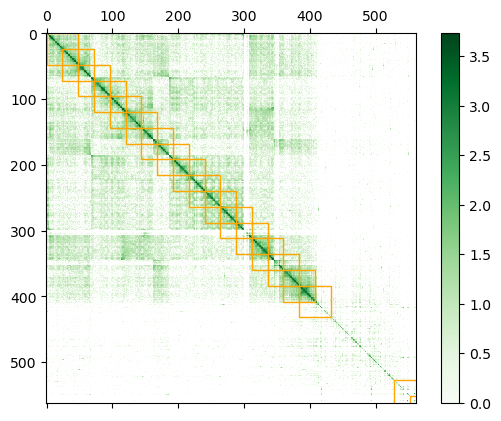

In [256]:
c = cooler.Cooler(f'{local_path}{file_path}::/resolutions/{resolution_1}')
skip = 0#c.chromsizes['2R']//resolution_1 #c.chromsizes['X']//resolution_1 + c.chromsizes['2R']//resolution_1 

matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])
fig = plt.figure()
  
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)

for det in detected:
    x = det[0] - skip
    y = det[1] - skip
    if x >= 0 and y >= 0:
        rect1 = patches.Rectangle((x, y), image_size_1, image_size_1, color='orange', fc = 'none', lw = 1)
        ax.add_patch(rect1)

plt.show()

## Perfrom next-level detection

In [231]:
resolution_2 = 10000

matrices_det = []
c = cooler.Cooler(f'{local_path}{file_path}::/resolutions/{resolution_2}').matrix(balance=False)
for d in detected:
    mat = np.log10(c[d[0]:min(d[0]+int(image_size_1*5), c.shape[0]), d[1]:min(d[1]+int(image_size_1*5), c.shape[1])])
    matrices_det.append((mat, d[0]))

In [257]:
image_size_2 = 48

class PatchesDiagDataset(Dataset):
    def __init__(self, patches_coords_list, image_size_old, image_size_new, res_old, res_new, step):
        self.blur = GaussianBlur(kernel_size=3, sigma=1)
        res_coef = res_old//res_new
        mini_patches_coords_list = []
        for patch, coord in patches_coords_list:
            corner_coord = coord*res_coef
            for i in range(0, patch.shape[0]-image_size_new, step):
                mini_patch = patch[i:i+image_size_new, i:i+image_size_new]
                mini_coord = corner_coord + i
                mini_patches_coords_list.append((mini_patch, mini_coord))
        self.patches_coords_list = mini_patches_coords_list
        self.image_size = image_size_new
    def __len__(self):
        return len(self.patches_coords_list)
    def __getitem__(self, idx):
        mat = np.nan_to_num(self.patches_coords_list[idx][0], neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)
        return tens, (self.patches_coords_list[idx][1], self.patches_coords_list[idx][1])



In [258]:
pathes_dataset = PatchesDiagDataset(matrices_det, image_size_1, image_size_2, resolution_1, resolution_2, image_size_2//2)
test_dataloader = DataLoader(pathes_dataset, batch_size=batch_size)
model.eval()
detected_2 = []
cur_tqdm = tqdm(test_dataloader)
for data, position in cur_tqdm:
    output = model(data)
    labels = torch.round(output).detach().cpu().numpy().reshape(-1)
    x_list = position[0][labels==1]
    y_list = position[1][labels==1]
    if len(x_list) > 0:
        for x, y in zip(x_list.numpy(), y_list.numpy()):
            detected_2.append((x, y))

100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


In [262]:
from matplotlib import patches
c = cooler.Cooler(f'{local_path}{file_path}::/resolutions/{resolution_2}')
matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])
fig = plt.figure()
  
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)

for det in detected_2:
    rect1 = patches.Rectangle((det[0],det[1]), image_size_2, image_size_2, color='orange', fc = 'none', lw = 0.1)
    ax.add_patch(rect1)

plt.savefig('output.png', dpi=1000)

MemoryError: Unable to allocate 60.2 MiB for an array with shape (2809, 2809) and data type float64

Error in callback <function _draw_all_if_interactive at 0x000001DD9CBA2B90> (for post_execute):


MemoryError: Unable to allocate 60.2 MiB for an array with shape (2809, 2809) and data type float64

MemoryError: Unable to allocate 60.2 MiB for an array with shape (2809, 2809) and data type float64

<Figure size 640x480 with 2 Axes>

In [19]:
coords_set = set()
for d in detected_2:
    coords_set.add(d[0]+(image_size_2//2))

In [20]:
class PatchesDataset(Dataset):
    def __init__(self, cooler_path, resolution, image_size, coords):
        self.resolution = resolution
        self.image_size = image_size
        c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}').matrix(balance=False)
        self.cooler = c
        patches_list = []
        coords_list = []
        pad = image_size//2
        for x in tqdm(coords):
            for y in coords:
                if x < y or  abs(x-y)<image_size: 
                    continue
                if x-pad < 0 or y - pad < 0:
                    mv = max(-(x-pad), -(y-pad))
                    x+=mv
                    y+=mv
                if x + pad > c.shape[0] or y + pad > c.shape[1]:
                    mv = max(-c.shape[0]-(x+pad), -c.shape[0]-(y+pad))
                    x-=mv
                    y-=mv
                mat = np.log10(c[x-int(image_size//2):x+int(image_size//2), y-int(image_size//2):y+int(image_size//2)])
                mat = np.nan_to_num(mat, neginf=0, posinf=0)
                assert mat.shape[0]==image_size
                assert mat.shape[1]==image_size
                patches_list.append(mat)
                coords_list.append((x, y))
        self.patches_list = patches_list
        self.coords_list = coords_list

    def __len__(self):
        return len(self.patches_list)

    def __getitem__(self, idx):
        mat = self.patches_list[idx]
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        return tens, self.coords_list[idx]

In [21]:
image_size_3 = 48
pathes_dataset = PatchesDataset(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool', resolution_2, image_size_3, coords_set)
test_dataloader = DataLoader(pathes_dataset, batch_size=batch_size)
model.eval()
detected_3 = []
cur_tqdm = tqdm(test_dataloader)
for data, position in cur_tqdm:
    output = model(data)
    labels = torch.round(output).detach().cpu().numpy().reshape(-1)
    x_list = position[0][labels==1]
    y_list = position[1][labels==1]
    if len(x_list) > 0:
        for x, y in zip(x_list.numpy(), y_list.numpy()):
            detected_3.append((x, y))

  0%|          | 0/547 [00:00<?, ?it/s]C:\Users\vit\AppData\Local\Temp\ipykernel_15772\1833905920.py:22: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(c[x-int(image_size//2):x+int(image_size//2), y-int(image_size//2):y+int(image_size//2)])
100%|██████████| 291/291 [00:13<00:00, 21.47it/s]


C:\Users\vit\AppData\Local\Temp\ipykernel_15772\2437628768.py:2: RuntimeWarning: divide by zero encountered in log10
  matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])


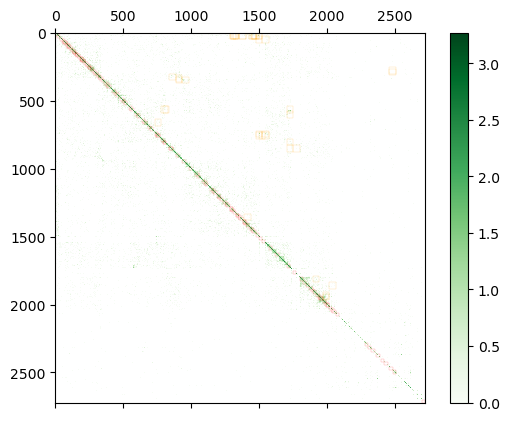

In [22]:
c = cooler.Cooler(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution_2}')
matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])
fig = plt.figure()
  
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)

for det in detected_3:
    rect1 = patches.Rectangle((det[0]-image_size_3//2,det[1]-image_size_3//2), image_size_3, image_size_3, color='orange', fc = 'none', lw = 0.1)
    ax.add_patch(rect1)
for det in detected_2:
    rect1 = patches.Rectangle((det[0],det[1]), image_size_2, image_size_2, color='red', fc = 'none', lw = 0.1)
    ax.add_patch(rect1)
plt.savefig('output.png', dpi=1000)

In [42]:
class ClarifyDataset(Dataset):
    def __init__(self, cooler_path, resolution, image_size, coords, patch_size, patch_resolution, step=1):
        self.resolution = resolution
        self.image_size = image_size
        c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}').matrix(balance=False)
        self.cooler = c
        patches_list = []
        coords_list = []
        pad = image_size//2
        res_coef = patch_resolution//resolution
        coords_set = set()
        for x, y in tqdm(coords):
            for i in range(0, patch_size, step):
                for j in range(0, patch_size, step):
                    x_i = (x-(patch_size//2) + i)*res_coef
                    y_j = (y-(patch_size//2) + j)*res_coef
                    if x_i-pad < 0 or y_j - pad < 0 or x_i + pad > c.shape[0] or y_j + pad > c.shape[1]:
                        continue
                    if (x_i, y_j) in coords_set:
                        continue
                    coords_set.add((x_i, y_j))
                    mat = c[x_i-pad:x_i+pad, y_j-pad:y_j+pad]
                    assert mat.shape[0]==image_size
                    assert mat.shape[1]==image_size

                    mat = np.log10(mat)
                    mat = np.nan_to_num(mat, neginf=0, posinf=0)
                    
                    patches_list.append(mat)
                    coords_list.append((x_i, y_j))
        self.patches_list = patches_list
        self.coords_list = coords_list

    def __len__(self):
        return len(self.patches_list)

    def __getitem__(self, idx):
        mat = self.patches_list[idx]
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        return tens, self.coords_list[idx]

In [36]:
image_size_4 = 16
pathes_dataset = ClarifyDataset(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool', resolution_2, image_size_4, detected_3, image_size_3, resolution_2)
test_dataloader = DataLoader(pathes_dataset, batch_size=batch_size)
model.eval()
detected_4 = []
cur_tqdm = tqdm(test_dataloader)
for data, position in cur_tqdm:
    output = model(data)
    labels = torch.round(output).detach().cpu().numpy().reshape(-1)
    x_list = position[0][labels==1]
    y_list = position[1][labels==1]
    if len(x_list) > 0:
        for x, y in zip(x_list.numpy(), y_list.numpy()):
            detected_4.append((x, y))

100%|██████████| 1347/1347 [01:28<00:00, 15.16it/s]


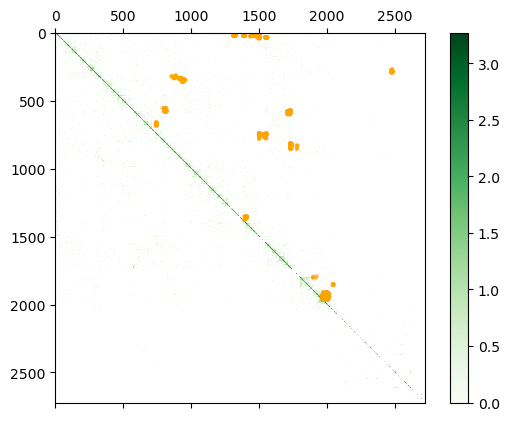

In [37]:
c = cooler.Cooler(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution_2}')
matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])
fig = plt.figure()
  
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)

for det in detected_4:
    rect1 = patches.Rectangle((det[0]-image_size_4//2,det[1]-image_size_4//2), image_size_4, image_size_4, color='orange', fc = 'none', lw = 0.1)
    ax.add_patch(rect1)
plt.savefig('output.png', dpi=1000)

In [43]:
image_size_4 = 16
resolution_3 = 1000
pathes_dataset = ClarifyDataset(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool', resolution_3, image_size_4, detected_4, image_size_4, resolution_2, step=16)
test_dataloader = DataLoader(pathes_dataset, batch_size=batch_size)
model.eval()
detected_5 = []
cur_tqdm = tqdm(test_dataloader)
for data, position in cur_tqdm:
    output = model(data)
    labels = torch.round(output).detach().cpu().numpy().reshape(-1)
    x_list = position[0][labels==1]
    y_list = position[1][labels==1]
    if len(x_list) > 0:
        for x, y in zip(x_list.numpy(), y_list.numpy()):
            detected_5.append((x, y))

  0%|          | 0/175028 [00:00<?, ?it/s]

100%|██████████| 216/216 [00:07<00:00, 28.30it/s]


In [46]:
detected_5

[(43240, 43230),
 (44800, 44780),
 (44800, 44790),
 (44810, 44790),
 (44830, 44780),
 (45760, 45750),
 (46240, 46230),
 (46260, 46220),
 (190310, 184980),
 (46720, 46710),
 (48400, 48390),
 (68980, 68760),
 (212320, 212310),
 (212440, 212430),
 (70360, 70350),
 (196600, 196580),
 (196600, 196590),
 (217360, 217350),
 (198920, 31140),
 (198930, 31130),
 (198920, 114360),
 (180880, 180860),
 (180880, 180870),
 (39520, 39510),
 (80920, 80910)]

In [ ]:
c = cooler.Cooler(f'{local_path}data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution_3}')
matrix = np.log10(c.matrix(balance=False).fetch('X'))#[:4631][:4631])
fig = plt.figure()
  
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)

for det in detected_5:
    rect1 = patches.Rectangle((det[0]-image_size_4//2,det[1]-image_size_4//2), image_size_4, image_size_4, color='orange', fc = 'none', lw = 0.1)
    ax.add_patch(rect1)
plt.savefig('output.png', dpi=1000)

In [3]:
image_size_4 = 48

detected = np.genfromtxt(f"{local_path}stage4.csv", delimiter=",")
detected = detected[np.argsort(detected.sum(axis=1))]
intersec_dist = image_size_4*np.sqrt(2)
def dist(d1, d2):
    return np.sqrt(((d1[0]-d2[0])**2)+((d1[1]-d2[1])**2))

i = 0
groups = []
while i < len(detected):
    for j in range(i, len(detected)):
        
        if j == (len(detected)-1) or dist(detected[j], detected[j+1]) > intersec_dist:
            break
    center = (detected[i][0]//2 + detected[j][0]//2, detected[i][1]//2 + detected[j][1]//2)
    left_up = (int(min(detected[i][0], detected[j][0])-image_size_4//2), int(min(detected[i][1], detected[j][1])-image_size_4//2))
    width = int(abs(detected[i][0] - detected[j][0]) + image_size_4)
    height = int(abs(detected[i][1] - detected[j][1]) + image_size_4)
    i=j+1
    groups.append((left_up, (width, height)))

groups_merged = []
i = 0
#while i < len(groups):
#    for j in range(i, len(groups)):
#        
#        if j == (len(groups)-1) or dist(groups[j][0], groups[j+1][0]) > max(groups[j][1], groups[j+1][1]):
#            break
#    left_up = (min(groups[i][0][0], groups[j][0][0]), min(groups[i][0][1], groups[j][0][1]))
#    size = dist(groups[i][0], groups[j][0]) + groups[i][1] + groups[j][1]
#    i=j+1
#    groups_merged.append((left_up, size))

In [6]:
import numpy as np

patch = np.random.rand(20)
print(patch)
print(patch[10])
patch[10-6:10+6]

[0.59797202 0.65370507 0.71110889 0.30272245 0.73254804 0.6062242
 0.48736395 0.22877416 0.22713437 0.93451922 0.99639083 0.35657962
 0.12575046 0.29703639 0.39857281 0.83546343 0.45543604 0.55957545
 0.74754724 0.26619326]
0.9963908341367171


array([0.73254804, 0.6062242 , 0.48736395, 0.22877416, 0.22713437,
       0.93451922, 0.99639083, 0.35657962, 0.12575046, 0.29703639,
       0.39857281, 0.83546343])

C:\Users\vit\AppData\Local\Temp\ipykernel_22520\3085967990.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix = np.log10(c.matrix(balance=False).fetch('2R'))#[:4631][:4631])


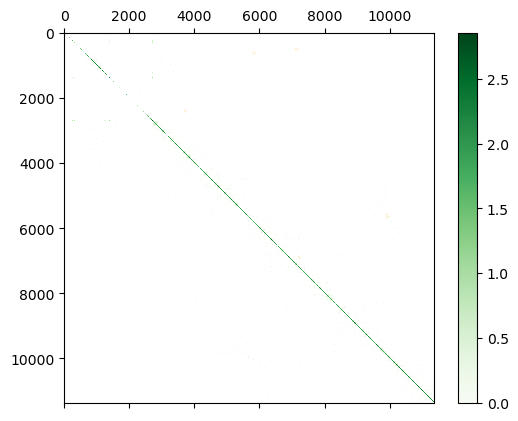

In [6]:
resolution_4 = 5000

local_path = 'D:/Study/HICT/HICT_Patterns/'

c = cooler.Cooler(f'{local_path}data/dong_vs_gambiae/dong_colluzzii_4DN.mcool::/resolutions/{resolution_4}')
matrix = np.log10(c.matrix(balance=False).fetch('2R'))#[:4631][:4631])
fig = plt.figure()
skip = c.chromsizes['X']//resolution_4

ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')
fig.colorbar(im)
for det in groups:
    x = det[0][0] - skip
    y = det[0][1] - skip
    if x > 0 and y > 0:
        rect1 = patches.Rectangle((x, y), det[1][0], det[1][1], color='orange', fc = 'none', lw = 0.1)
        ax.add_patch(rect1)
        
plt.savefig('output_grouped.png', dpi=1000)

In [7]:
class ArbitraryPatchesDataset(Dataset):
    def __init__(self, cooler_path, resolution, patches_borders_list, image_size, step=1):
        self.resolution = resolution
        c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}').matrix(balance=False)
        self.patches_list = []
        self.coords_list = []
        self.group_indexes_list = []
        self.image_size = image_size
        for patch_borders in patches_borders_list:
            big_patch = c[patch_borders[0][0]:patch_borders[0][0]+patch_borders[1][0], patch_borders[0][1]:patch_borders[0][1]+patch_borders[1][1]]
            self.patches_list.append(big_patch)
            self.coords_list.append((patch_borders[0][0], patch_borders[0][1]))
    def __len__(self):
        return len(self.patches_list)

    def __getitem__(self, idx):
        mat = self.patches_list[idx]
        return mat, self.coords_list[idx]

In [68]:
def perform_ingroup_detection(model, dataloader):
    detected = []
    cur_tqdm = tqdm(dataloader)
    for data, position, group_idx in cur_tqdm:
        output = model(data)

        labels = torch.round(output).detach().cpu().numpy().reshape(-1)
        x_list = position[0][labels==1]
        y_list = position[1][labels==1]
        scores = output[labels==1]
        groups = group_idx[labels==1]
        if len(x_list) > 0:
            for x, y, score, group in zip(x_list.numpy(), y_list.numpy(), scores.detach().cpu().numpy(), groups.numpy()):
                if group >= len(detected):
                    detected.append([])
                detected[group].append((x, y, score))

    fin_detected = []
    for group in detected:
        max_score = 0
        for x, y, score in group:
            if score > max_score:
                res_x = x
                res_y = y
        fin_detected.append((res_x, res_y))
    return fin_detected

In [8]:
image_size_5 = 24
resolution_4 = 5000
file_path = 'data/dong_vs_gambiae/dong_colluzzii_4DN.mcool'

dataset = ArbitraryPatchesDataset(f'{local_path}{file_path}', resolution_4, groups, image_size_5)

In [58]:
detected = []
dataloader = DataLoader(dataset, batch_size=1)
cur_tqdm = tqdm(dataloader)
for data, position in cur_tqdm:
    center = np.unravel_index(data[0].cpu().numpy().argmax(), data[0].shape)
    dot = ((position[0].item()+center[0], position[1].item()+center[1]))
    detected.append(dot)

100%|██████████| 14/14 [00:00<00:00, 15947.92it/s]


In [85]:
model = DetectModel(image_size=image_size_5)
model.to(device)
model.load_state_dict(torch.load(f'{local_path}artifacts/torch_ensemble_5k_24_clr.pt', map_location=device))
model.eval()

detected_5 = perform_ingroup_detection(model, DataLoader(dataset, batch_size=batch_size))

100%|██████████| 47/47 [00:10<00:00,  4.56it/s]


In [57]:
np.savetxt(f"{local_path}stage5.csv",
        detected,
        delimiter =",",
        fmt ='% s')

## Classification

In [24]:
train_coolers = []
train_csvs = []
test_coolers = []
test_csvs = []

train_coolers.append(f'{local_path}data/ZANU/ZANU_long_4DN.mcool')
train_csvs.append(f'{local_path}data/ZANU/transitions_long.csv')
train_coolers.append(f'{local_path}data/arab/ARAB_del_4DN.mcool')
train_csvs.append(f'{local_path}data/arab/deletions_1M.csv')

test_coolers.append(f'{local_path}data/ZANU/ZANU_short_4DN.mcool')
test_csvs.append(f'{local_path}data/ZANU/transitions_short.csv')
test_coolers.append(f'{local_path}data/arab/ARAB_del_4DN.mcool')
test_csvs.append(f'{local_path}data/arab/deletions_1M.csv')


train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=5000,
    image_size=24,
    detection=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TrainDatasetPatches(
    cooler_path_list=test_coolers,
    trans_csv_path_list=test_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=5000,
    image_size=24,
    detection=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

C:\Users\vit\AppData\Local\Temp\ipykernel_3292\3101554702.py:80: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(mat)


tensor([1., 0., 0.])


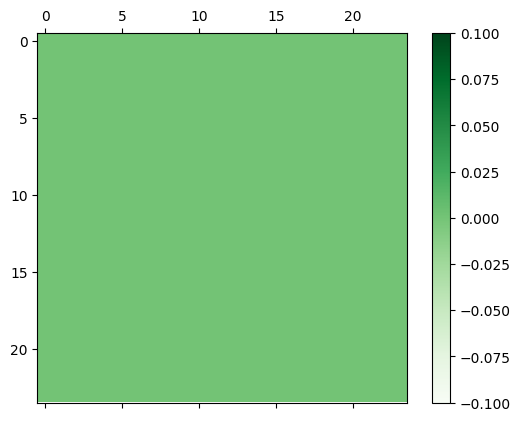

In [14]:
for batch in train_dataloader:
    for data, label in zip(batch[0], batch[1]):
        if label[0] == 1:
            print(label)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            im = ax.matshow(data.cpu().numpy().reshape((24, 24)), cmap='Greens')
            fig.colorbar(im)
            break
    break

In [25]:
model = ClassificationModel(in_channels=1, image_size=24, num_models=10, num_classes=3)
model.to(device=device)

import torch.optim as optim

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
from sklearn import metrics

def run_epoch(model, phase, dataloader):
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_loss = 0.0
  running_corrects = 0
  y_test = []
  y_pred = []
  all_elems_count = 0
  cur_tqdm = tqdm(dataloader)
  for inputs, labels in cur_tqdm:
    bz = inputs.shape[0]
    all_elems_count += bz
    
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True, dtype=torch.float)

    outputs = model(inputs)
    print(outputs)
    loss = criterion(outputs, labels)
    if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = torch.argmax(outputs, dim=1)
    y_test.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    running_loss += loss.item() * bz
    corrects_cnt = torch.sum(preds == torch.argmax(labels.detach(), dim=1))
    running_corrects += corrects_cnt
    show_dict = {'Loss': f'{loss.item():.6f}',
                'Corrects': f'{corrects_cnt.item()}/{bz}',
                'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
    cur_tqdm.set_postfix(show_dict)

  print("Calculating metrics...")
  epoch_loss = running_loss / all_elems_count
  epoch_acc = running_corrects.float().item() / all_elems_count
  return epoch_loss, epoch_acc

def test_epoch(model, dataloader):
    with torch.inference_mode():
      return run_epoch(model,'test', dataloader)

def train_epoch(model, dataloader):
    return run_epoch(model, 'train', dataloader)

In [27]:
import time
import math
import matplotlib.pyplot as plt
import os

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, model, num_epochs=20):
  print(f"Training model with params:")
  print(f"Optim: {optimizer}")
  print(f"Criterion: {criterion}")

  phases = ['train', 'test']
  for phase in dataloaders:
      if phase not in phases:
          phases.append(phase)

  saved_epoch_losses = {phase: [] for phase in phases}
  saved_epoch_accuracies = {phase: [] for phase in phases}

  for epoch in range(1, num_epochs + 1):
      start_time = time.time()

      print("=" * 100)
      print(f'Epoch {epoch}/{num_epochs}')
      print('-' * 10)

      for phase in phases:
          print("--- Cur phase:", phase)
          epoch_loss, epoch_acc = \
              train_epoch(model, dataloaders[phase]) if phase == 'train' \
                  else test_epoch(model, dataloaders[phase])
          saved_epoch_losses[phase].append(epoch_loss)
          saved_epoch_accuracies[phase].append(epoch_acc)
          print(f'{phase} loss: {epoch_loss:.6f}, '
                f'acc: {epoch_acc:.6f}')

      if epoch == num_epochs:
        plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel(criterion.__class__.__name__)
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

        plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

      end_time = time.time()
      epoch_time = end_time - start_time
      print("-" * 10)
      print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

  print("*** Training Completed ***")

  return saved_epoch_losses, saved_epoch_accuracies

In [31]:
num_epochs = 10
dataloaders = dict()
dataloaders['train'] = train_dataloader
dataloaders['test'] =  test_dataloader
train_model(dataloaders, model, num_epochs)

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\vit\AppData\Local\Temp\ipykernel_3292\1005011150.py:80: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(mat)
C:\Users\vit\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 50%|█████     | 1/2 [00:02<00:02,  2.95s/it, Loss=0.580949, Corrects=497/512, Accuracy=97.070%]

tensor([[9.9691e-01, 2.0776e-03, 1.0091e-03],
        [3.9555e-12, 9.1368e-08, 1.0000e+00],
        [9.9886e-01, 7.0598e-04, 4.3352e-04],
        ...,
        [9.9772e-01, 1.9664e-03, 3.1127e-04],
        [3.2757e-01, 6.6869e-01, 3.7332e-03],
        [6.3138e-07, 1.0000e+00, 8.9971e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


100%|██████████| 2/2 [00:04<00:00,  2.06s/it, Loss=0.574510, Corrects=264/270, Accuracy=97.778%]


tensor([[9.9812e-01, 1.5388e-03, 3.3631e-04],
        [4.4807e-08, 1.0000e+00, 5.2702e-07],
        [9.2984e-11, 1.0000e+00, 1.1522e-08],
        [5.3848e-08, 1.0404e-06, 1.0000e+00],
        [3.0646e-11, 3.7045e-06, 1.0000e+00],
        [9.9667e-01, 2.6804e-03, 6.5356e-04],
        [1.7759e-09, 1.0000e+00, 7.0477e-08],
        [5.7366e-08, 1.0000e+00, 3.0102e-07],
        [9.9862e-01, 1.0133e-03, 3.6343e-04],
        [1.5778e-08, 4.7156e-04, 9.9953e-01],
        [9.9841e-01, 1.3157e-03, 2.7057e-04],
        [9.9888e-01, 7.9809e-04, 3.2222e-04],
        [1.2206e-10, 3.5786e-08, 1.0000e+00],
        [9.9828e-01, 1.2133e-03, 5.0894e-04],
        [7.0318e-09, 1.0000e+00, 3.0078e-07],
        [5.0758e-10, 1.0000e+00, 3.6083e-08],
        [9.9854e-01, 1.2689e-03, 1.9020e-04],
        [9.9628e-01, 3.2282e-03, 4.9146e-04],
        [1.8466e-10, 1.6806e-06, 1.0000e+00],
        [9.9825e-01, 1.4722e-03, 2.7636e-04],
        [1.6075e-06, 9.9996e-01, 4.3255e-05],
        [9.9838e-01, 1.2838e-03, 3

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [29]:
torch.save(model.state_dict(), f'{local_path}artifacts/torch_ensemble_5k_24_classify_bl.pt')